# This notebook defines Level 1 sub-macro regions based on the L0 macro regions.
It follows the same flow as L0: load the Admin 0_all_layers dataset,
prepare names/codes, define L1 sub-macro regions, validate coverage,
and plot results.


## 1. Load data


In [11]:
from pathlib import Path
import geopandas as gpd

base_dir = Path.cwd().parents[0]
data_dir = base_dir / "Data" / "World Bank Official Boundaries - Admin 0_all_layers"
shp_path = data_dir / "WB_GAD_ADM0_complete_H2RES.shp"
gdf = gpd.read_file(shp_path)

## 3. Define L1 sub-macro regions (LAC)


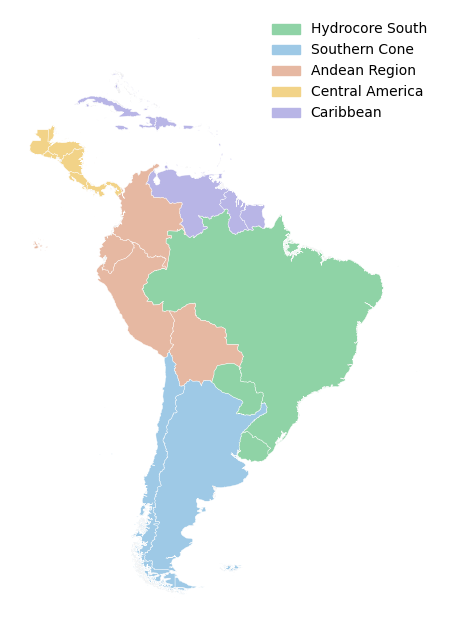

In [26]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- DATA ---
base_dir = Path.cwd().parents[0]
data_dir = base_dir / "Data" / "World Bank Official Boundaries - Admin 0_all_layers"
shp_path = data_dir / "WB_GAD_ADM0_complete.shp"
gdf = gpd.read_file(shp_path)

# --- LISTS ---
SOUTH_AMERICA = [
    'Anguilla (U.K.)','Aruba (Neth.)','Antigua and Barbuda','Argentina',
    'Barbados','Belize','Bermuda (U.K.)','Bonaire, Sint Eustatius and Saba (Neth.)',
    'British Virgin Islands (U.K.)','Cayman Islands (U.K.)',
    'Bolivia','Brazil','Curacao (Neth.)','Cuba','Chile','Colombia','Costa Rica','Dominica',
    'Dominican Republic','Ecuador','El Salvador','Grenada','Guatemala',
    'Guyana','Haiti','Honduras','Jamaica','Nicaragua','Panama',
    'Paraguay','Peru','Republica Bolivariana de Venezuela','Saint Kitts and Nevis',
    'Saint Lucia','Saint Vincent and the Grenadines','Suriname','The Bahamas',
    'Trinidad and Tobago','Uruguay','Falkland Islands','Montserrat (U.K.)',
    'Puerto Rico (U.S.)','Saint-Barthelemy (Fr.)','Saint-Martin (Fr.)',
    'Sint Maarten (Neth.)','Turks and Caicos Islands (U.K.)','United States Virgin Islands (U.S.)',
    'French Guyana','Guadalupe (Fr.)','Martinique (Fr.)'
]

LAC_REGIONS = {
    'Hydrocore South': [
        'Brazil','Uruguay','Paraguay'
    ],
    'Southern Cone': [
        'Argentina','Chile','Falkland Islands'
    ],
    'Andean Region': [
        'Colombia','Peru','Ecuador','Bolivia'
    ],
    'Central America': [
        'Belize','Guatemala','Honduras','El Salvador',
        'Nicaragua','Costa Rica','Panama'
    ],
    'Caribbean': [
        'Cuba','Haiti','Dominican Republic','Jamaica','Trinidad and Tobago',
        'The Bahamas','Barbados','Grenada','Dominica',
        'Antigua and Barbuda','Saint Kitts and Nevis','Saint Lucia',
        'Saint Vincent and the Grenadines',
        'Anguilla (U.K.)','Aruba (Neth.)','Bermuda (U.K.)','British Virgin Islands (U.K.)',
        'Cayman Islands (U.K.)','Curacao (Neth.)','Montserrat (U.K.)','Puerto Rico (U.S.)',
        'Saint-Barthelemy (Fr.)','Saint-Martin (Fr.)','Sint Maarten (Neth.)',
        'Turks and Caicos Islands (U.K.)','United States Virgin Islands (U.S.)',
        'Republica Bolivariana de Venezuela','Suriname','Guyana','French Guyana',
        'Guadalupe (Fr.)','Martinique (Fr.)','Bonaire, Sint Eustatius and Saba (Neth.)'
    ]
}

colors = {
    "Hydrocore South": "#8FD3A6",
    "Southern Cone": "#9EC9E6",
    "Andean Region": "#E6B8A2",
    "Central America": "#F2D388",
    "Caribbean": "#B8B5E6"
}

# --- ASSIGN SUBREGIONS ---
lac_gdf = gdf[gdf["NAM_0"].isin(SOUTH_AMERICA)].copy()
lac_gdf["LAC_Region"] = None
for region, countries in LAC_REGIONS.items():
    lac_gdf.loc[lac_gdf["NAM_0"].isin(countries), "LAC_Region"] = region

# --- LIGHTWEIGHT MAP ---
lac_plot = lac_gdf.copy()
lac_plot["geometry"] = lac_plot["geometry"].simplify(0.05, preserve_topology=True)

out_dir = base_dir / "Maps" / "Layer1"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "L1_LAC.pdf"

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
lac_plot.plot(
    ax=ax,
    color=lac_plot["LAC_Region"].map(colors),
    linewidth=0.3,
    edgecolor="white"
)

legend_handles = [mpatches.Patch(color=colors[k], label=k) for k in colors]
ax.legend(handles=legend_handles, loc="upper right", frameon=False)
ax.set_axis_off()

fig.savefig(out_path, dpi=150, bbox_inches="tight")
